In [19]:
import pandas as pd

from rmexp import schema
from rmexp.utilityfunc import app_default_utility_func


In [46]:
df = pd.read_sql("select * from ExpLatency", schema.engine).drop(['id', 'date'], axis=1)
df['per_frame_util'] = df.apply(
    lambda r: app_default_utility_func[r['app']](r['reply']),
    axis=1
)
df['index_int'] = df['index'].astype(int)
df.head(20)

,name,index,val,app,client,arrival,finished,reply,per_frame_util,index_int
0,lego1-ours,1,None,lego,0,11,192,193,1.0,1
1,lego1-ours,3,None,lego,0,11,202,224,1.0,3
2,lego1-ours,10,None,lego,0,16,196,197,1.0,10
3,lego1-ours,11,None,lego,0,15,197,222,1.0,11
4,lego1-ours,17,None,lego,0,18,110,111,1.0,17
5,lego1-ours,18,None,lego,0,16,131,132,1.0,18
6,lego1-ours,21,None,lego,0,12,199,200,1.0,21
7,lego1-ours,23,None,lego,0,16,175,186,1.0,23
8,lego1-ours,28,None,lego,0,19,147,148,1.0,28
9,lego1-ours,29,None,lego,0,17,138,149,1.0,29


In [18]:
util_summary = df.groupby(['name', 'app']).agg('mean')
util_summary.head(30)

arrival    finished       reply  \
name                              app                                           
lego1-baseline                    lego      14.964768  104.601949  107.965517   
lego1-ours                        lego      14.374106  100.122318  103.368383   
lego1pingpong1-baseline           lego      13.791971   94.516058   97.823358   
                                  pingpong  15.089787  156.592593  159.803591   
lego1pingpong1-ours               lego      14.477157   96.991298  100.644670   
                                  pingpong  15.919822  160.178174  164.206013   
lego1pingpong1face1-baseline      face      16.841328  291.409594  293.924354   
                                  lego      17.239289  143.088819  148.340648   
                                  pingpong  17.216080  253.351759  258.145729   
lego1pingpong1face1-ours          face      17.669468  462.689076  466.932773   
                                  lego      14.847584  127.118959  131.340149   
                                  pingpong  16.163782  195.872170  199.832224   
lego1pingpong1face1pool1-baseline face      16.729216  382.973872  386.028504   
                                  lego      17.401907  197.020436  202.245232   
                                  pingpong  18.261682  371.976636  376.301402   
                                  pool      22.055385  502.458462  506.858462   
lego1pingpong1face1pool1-ours     face      35.958791  444.969780  449.376374   
                                  lego      17.623750  176.626250  182.461250   
                                  pingpong  16.700508  249.082910  255.585448   
                                  pool      21.227848  509.126582  516.278481   

                                            per_frame_util  
name                              app                       
lego1-baseline                    lego        9.999984e-01  
lego1-ours                        lego        9.999987e-01  
lego1pingpong1-baseline           lego        9.999906e-01  
                                  pingpong    7.530528e-01  
lego1pingpong1-ours               lego        9.999407e-01  
                                  pingpong    7.242507e-01  
lego1pingpong1face1-baseline      face        9.997597e-01  
                                  lego        9.996444e-01  
                                  pingpong    5.206663e-01  
lego1pingpong1face1-ours          face        9.731107e-01  
                                  lego        9.995306e-01  
                                  pingpong    5.941973e-01  
lego1pingpong1face1pool1-baseline face        9.928966e-01  
                                  lego        9.980702e-01  
                                  pingpong    4.741892e-01  
                                  pool        1.463514e-18  
lego1pingpong1face1pool1-ours     face        9.867630e-01  
                                  lego        9.894872e-01  
                                  pingpong    5.787470e-01  
                                  pool        9.884446e-21

In [21]:
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)

In [138]:
baseline_total_utilities = []
ours_total_utilities = []
experiments = ['lego1', 'lego1pingpong1', 'lego1pingpong1face1', 'lego1pingpong1face1pool1']
apps = ['lego', 'pingpong', 'face', 'pool']

BASELINE = 0
OURS = 1

utilities = {
    app: {
        experiment: [0, 0]
        for experiment in experiments
    }
    for app in apps
}

for experiment in experiments:
    baseline_df = df.loc[df['name'] == '{}-baseline'.format(experiment)]
    ours_df = df.loc[df['name'] == '{}-ours'.format(experiment)]
    
    baseline_total_utility = 0
    ours_total_utility = 0
    
    for app in apps:
        baseline_app_df = baseline_df.loc[baseline_df.app == app]
        ours_app_df = ours_df.loc[ours_df.app == app]
    
        if (baseline_app_df.shape[0] > 0 and ours_app_df.shape[0] > 0):
            max_index_baseline_app = baseline_app_df.index_int.max()
            max_index_ours_app = ours_app_df.index_int.max()
            max_index_app = min(max_index_baseline_app, max_index_ours_app)

            valid_baseline_app_df = baseline_app_df[baseline_app_df.index_int < max_index_app]
            valid_ours_app_df = ours_app_df[ours_app_df.index_int < max_index_app]

            baseline_app_utility = valid_baseline_app_df.per_frame_util.sum()
            ours_app_utility = valid_ours_app_df.per_frame_util.sum()
        else:
            baseline_app_utility = 0
            ours_app_utility = 0
    
        utilities[app][experiment][BASELINE] = baseline_app_utility
        utilities[app][experiment][OURS] = ours_app_utility
        
        baseline_total_utility += baseline_app_utility
        ours_total_utility += ours_app_utility
    
    baseline_total_utilities.append(baseline_total_utility)
    ours_total_utilities.append(ours_total_utility)

<IPython.core.display.Javascript object>


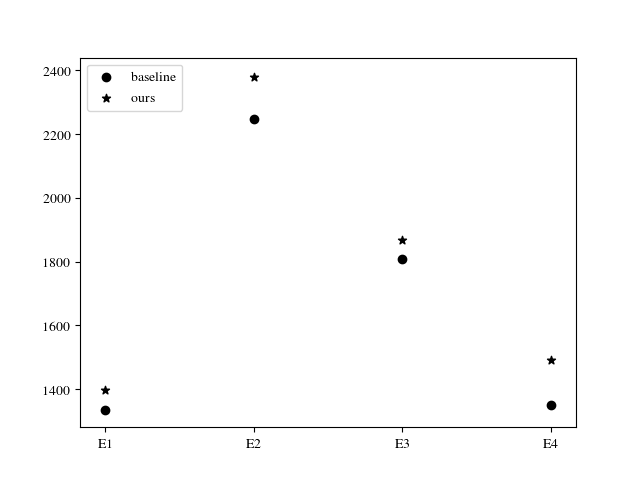

In [147]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

AXIS_TITLES = ['E1', 'E2', 'E3', 'E4']

ax1.scatter(AXIS_TITLES, baseline_total_utilities, color='k', marker='o', label='baseline')
ax1.scatter(AXIS_TITLES, ours_total_utilities, color='k', marker='*', label='ours')
plt.legend(loc='upper left');
plt.show()
plt.savefig('total-utilities.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


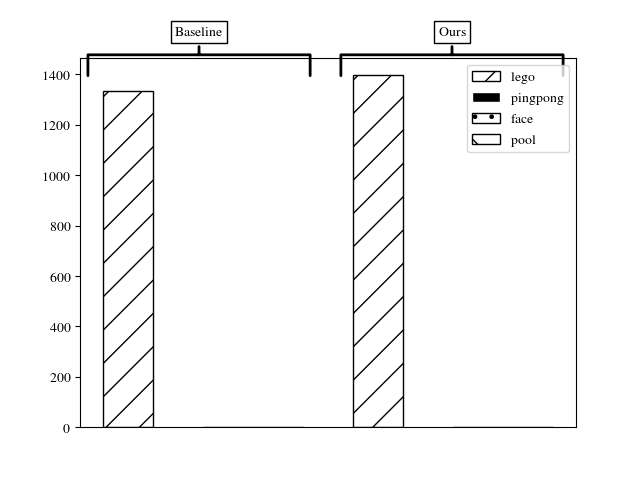

<IPython.core.display.Javascript object>


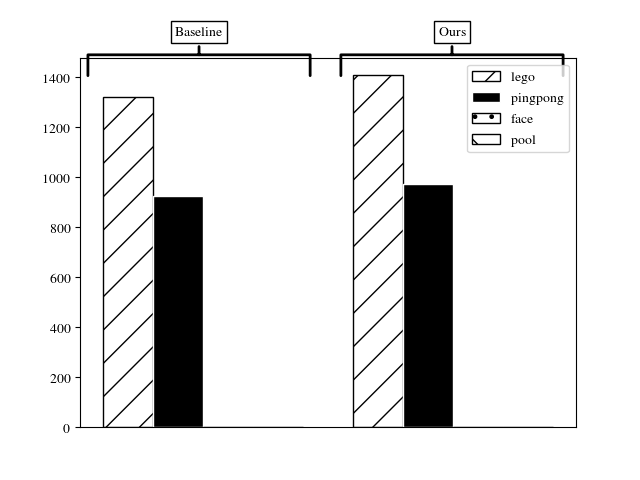

<IPython.core.display.Javascript object>


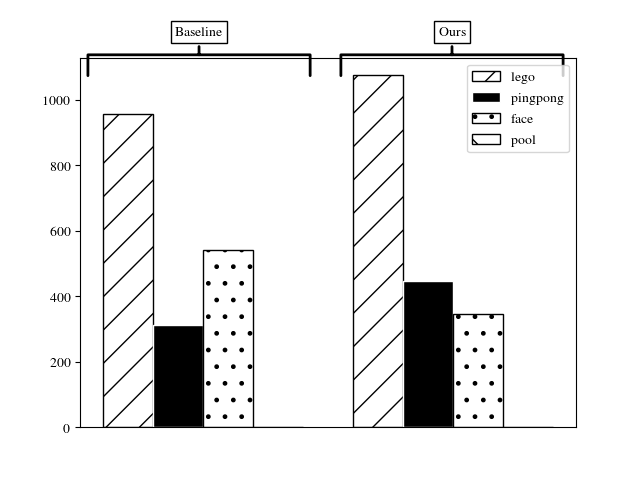

<IPython.core.display.Javascript object>


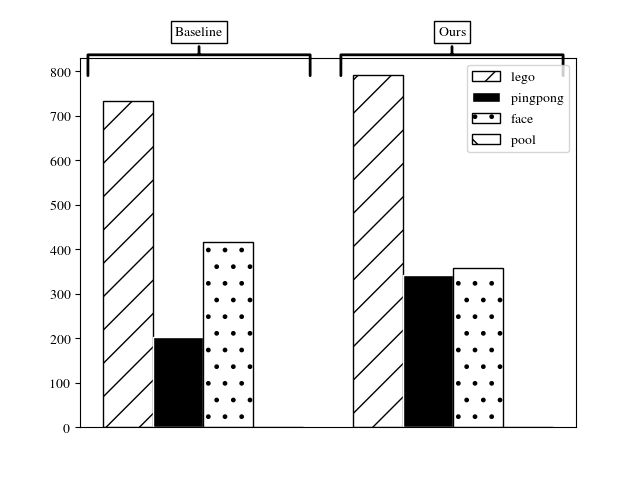

In [152]:
for experiment in experiments:
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.bar([0, 1], utilities['lego'][experiment], width=0.2, color='w', edgecolor='k', hatch='/', align='center', label='lego')
    ax.bar([0.2, 1.2], utilities['pingpong'][experiment], width=0.2, color='k', edgecolor='w', align='center', label='pingpong')
    ax.bar([0.4, 1.4], utilities['face'][experiment], width=0.2, color='w', edgecolor='k', hatch='.', align='center', label='face')
    ax.bar([0.6, 1.6], utilities['pool'][experiment], width=0.2, color='w', edgecolor='k', hatch='\\', align='center', label='pool')
    
    # https://stackoverflow.com/a/35322778/859277
    ax.annotate('Baseline', xy=(0.24, 1.00), xytext=(0.24, 1.05), xycoords='axes fraction', 
            ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=8, lengthB=1.5', lw=2.0))
    ax.annotate('Ours', xy=(0.75, 1.00), xytext=(0.75, 1.05), xycoords='axes fraction', 
            ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=8, lengthB=1.5', lw=2.0))
    ax.axes.get_xaxis().set_visible(False)

    plt.legend()
    plt.show()
    plt.savefig('utility-{}.pdf'.format(experiment), bbox_inches='tight')

In [144]:
df.loc[df['app'] == 'pool'].per_frame_util.sum()

4.7876557752371591e-16